In [1]:
from supply_chain import *

  0%|          | 0/50 [00:00<?, ?it/s]

Baseline cost:  -0.418697
Training...


cost: 0.408876 | model cost: 6.383721:   4%|▍         | 2/50 [00:01<00:38,  1.26it/s]/Users/qasimwani/opt/anaconda3/lib/python3.7/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
cost: -0.248503 | model cost: 0.167573: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Final cost:  -0.248503
Performance improvement: 40.65 % over baseline cost


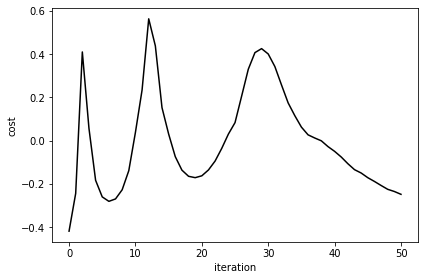

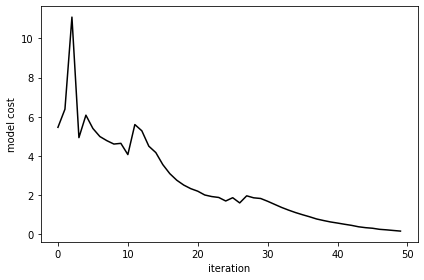

In [2]:
# parameters
time_horizon = 10
epochs = 50  # number of episodes to run for
cost_batch_size = 10  # batch size for cost calculation
replay_buffer_size = 5  # max memory size
replay_batch_size = 1  # training sample size -- train every `meta_episode`
lr = 0.05  # adam learning rate

agent = Agent(
    policy,
    time_horizon,
    cost_batch_size,
    replay_buffer_size,
    replay_batch_size,
    lr,
)

# get baseline cost
P_sqrt_baseline = torch.eye(n, dtype=torch.double)
q_baseline = -h_max * torch.ones(n, 1, dtype=torch.double)

baseline_params = [P_sqrt_baseline, q_baseline]

cost, _, _ = monte_carlo(
    policy,
    baseline_params,
    time_horizon,
    batch_size=1,
    trials=10,
    seed=0,
)
baseline_cost = np.mean(cost)
print("Baseline cost: ", round(baseline_cost, 6))

# perform training
print("Training...")

costs = []
pbar = tqdm(range(epochs))

for i in pbar:

    torch.manual_seed(i)

    agent.next()
    cost, _, _ = monte_carlo(
        agent.actor.policy,
        agent.actor.get_params(),
        time_horizon,
        batch_size=1,
        trials=10,
        seed=0,
    )
    costs.append(np.mean(cost))

    # update progress bar
    if i >= replay_batch_size: 
        txt = (
            "cost: "
            + str(round(costs[-1], 6))
            + " | "
            + "model cost: "
            + str(round(agent.actor.loss_progression[-1], 6))
        )
        pbar.set_description(txt)

print("Final cost: ", round(costs[-1], 6))

improvement = 100 * np.abs(costs[-1] - baseline_cost) / np.abs(baseline_cost)
print("Performance improvement: %.2f %% over baseline cost" % improvement)

# plot cost
plt.plot([baseline_cost] + costs, c="k", label="Loss")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.tight_layout()
plt.savefig("iAC_supply_chain_training.pdf")
plt.show()

# plot E2E costs
plt.plot(agent.actor.loss_progression, c="k", label="Loss")
plt.xlabel("iteration")
plt.ylabel("model cost")
plt.tight_layout()
plt.savefig("iAC_supply_chain_model_costs.pdf")
plt.show()


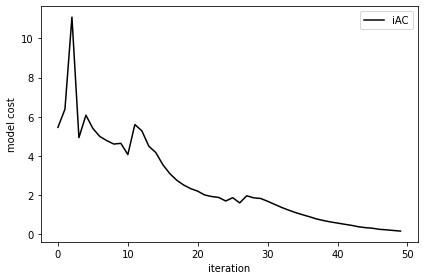

In [3]:
plt.plot(agent.actor.loss_progression, c="k", label="iAC")
plt.xlabel("iteration")
plt.ylabel("model cost")
plt.tight_layout()
plt.legend()
plt.savefig("iAC_supply_chain_training.pdf")
plt.show()

In [4]:
agent.actor.params_progression[-1]

[tensor([[ 0.7715, -0.2068, -0.1954, -0.1976],
         [-0.2016,  0.8187, -0.1702, -0.1723],
         [-0.1899, -0.1700,  0.8408, -0.1612],
         [-0.1924, -0.1724, -0.1615,  0.8364]], dtype=torch.float64,
        requires_grad=True),
 tensor([[-1.1771],
         [-1.2233],
         [-1.2465],
         [-1.2412]], dtype=torch.float64, requires_grad=True)]

In [5]:
p1, p2 = [], []
for e in agent.actor.grad_progression:
    p1.append(e[0].mean().item())
    p2.append(e[1].mean().item())

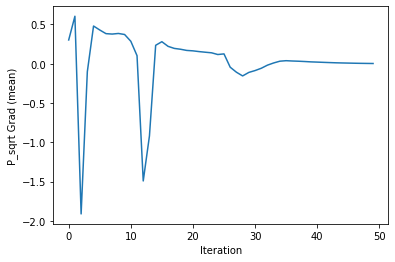

In [6]:
plt.plot(p1)
plt.xlabel("Iteration")
plt.ylabel("P_sqrt Grad (mean)")
plt.show()

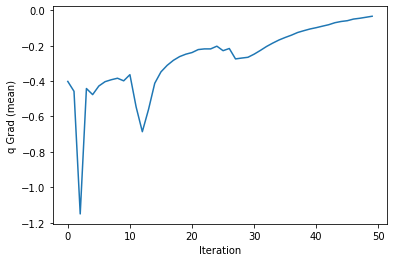

In [7]:
plt.plot(p2)
plt.xlabel("Iteration")
plt.ylabel("q Grad (mean)")
plt.show()

In [8]:
agent.critic[0].get_alphas()

[array(-0.00480559), array(0.03499887), array(0.00121172)]